In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Torch 
import torch
import torch.nn as nn
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader

# Scikit-Learn
# Data Encoding and Scaling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Natural Language Processing(NLP)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Word Embedding
import gensim
from gensim.models import Word2Vec

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
df = pd.read_csv('IntervieweeDataset.csv')

In [5]:
df.head(2)

,Name,Age,Gender,Type of Graduation/Post Graduation,Marital status,Mode of interview given by candidate?,Pre Interview Check,Fluency in English based on introduction,Confidence based on Introduction (English),Confidence based on the topic given,...,Structured Thinking Based on the PPT Question.1,Structured Thinking( Call pitch).1,Regional fluency based on the topic given .1,Regional fluency Based on the PPT Question.1,Regional fluency based on the sales scenario.1,Confidence Score,Structured Thinking Score,Regional Fluency Score,Total Score,Whether joined the company or not\n
0,parida,25,Female,Masters in data science,Unmarried,Mobile,Proceed with the Interview,Able to speak sentences in a clear/coherent wa...,Impactful - Good confidence throughout the Int...,Guarded Confidence - Confident in some areas a...,...,3,2,1,1.0,1.0,11,7,3,42,No
1,shreej,29,Female,BSc or MSc,Unmarried,Mobile,Proceed with the Interview,Able to speak sentences in a clear/coherent wa...,Impactful - Good confidence throughout the Int...,Impactful - Good confidence throughout the Int...,...,3,3,3,3.0,3.0,12,9,9,60,No


In [6]:
df.shape

(21256, 52)

In [7]:
df.dropna(inplace=True)

In [8]:
df.drop(df.iloc[:,8:18], axis=1, inplace=True)

In [9]:
df.drop(['Does the candidate has mother tongue influence while speaking english.', 'How many slides candidate have submitted in PPT?'], axis=1, inplace=True)

In [10]:
df.drop('Pre Interview Check', axis=1, inplace=True)

In [11]:
df.shape

(18681, 39)

In [12]:
df['Type of Graduation/Post Graduation'].unique()

array(['Masters in data science', 'BSc or MSc', 'B.E / B-Tech', 'BA/MA',
       'B.ed(Teaching)', 'M.E / M-Tech', 'B.com (Bachelor of commerce)',
       'MED', 'M.com', 'MBA', 'BCA/MCA',
       'B.comm (Bachelor of mass comm.)', 'BBA or BBM',
       'Hotel Management', 'PG diploma ', 'B.pharma/M.pharma', 'PGDM',
       'Bachelor in dental', 'pgdm', 'Bachelor in medical lab', 'Pgdm',
       'master maas comm', 'BE - CSe and CDAC ',
       'Bachelors in fisheries in science', 'LLM', 'PHD ', 'BMS',
       'B-pharma', 'bachlors in journalism-2021', 'msw-hr-2014', 'MS',
       'LLB', 'Mphil', 'b.com and pgdc , ', 'bachelor mass communication',
       'PG(Bachelor of Library Science)', 'MMC', 'MASTER IN MANGEMENT ',
       'pgdm ', 'M Phil', 'PGPM', 'PGPCEM', 'BA in French', 'B-pharm ',
       'PHARMA D', 'MJMC 2020', 'bms ', 'PGPM in marketing', 'MSW',
       'mass media', 'Bachelor of Tourism', 'MASTERS IN DESIGN ',
       'mass comm', 'Bled', 'msw', 'English Honors', 'mass com',
       'M

In [13]:
education_mapping = {
    'Engineering & Technology': [
        'B.E / B-Tech', 'M.E / M-Tech', 'B-Tech - INTEGRATED', 'BE - CSe and CDAC',
        'B.ENG', 'Bachelors of planning', 'B.Arch', 'Bachelor of Architecture', 'B.ARC'
    ],
    'Science & Medical': [
        'BSc or MSc', 'BSC', 'MS', 'Masters in biotechnology', 'PG - msc biochemistry',
        'Bio science', 'masters in biology', 'biotech', 'Masters of Statistics',
        'Bachelors in biotechnology', 'Ph D genetics', 'MBBS', 'Bachelor in medical lab',
        'B.Physiotherapist', 'B.pharma', 'M.pharma', 'B -pharm', 'B.PHARMA',
        'PHARMA D', 'pharm D', 'M.Pharma', 'Bachelors in dental',
        'Masters in Clinical Psychology', 'B.voc in applied clinical psychology'
    ],
    'Commerce & Business': [
        'B.com', 'BCOM COMPUTERS', 'Bcom computers', 'bcom -pa', 'M.com',
        'MBA', 'MBA- 2019', 'MBA agro business', 'PGDM', 'pgdm', 'PGDM 2022',
        'PGDM marketing', 'PG diploma in banking', 'PG DIPLOMA IN BANKING',
        'Masters in banking and insurance', 'BBA or BBM', 'BBM',
        'Bachelor of Business Economics (B.B.E.)', 'PGPM', 'PGPM in marketing',
        'PGPCEM', 'PGDBS', 'B.Voc - Banking & Finance'
    ],
    'Humanities & Social Sciences': [
        'BA/MA', 'LLB', 'LLM', 'MPhil', 'M.phil', 'Mphil 2020', 'PHD', 'doctorate',
        'Masters of Social Work (MSW)', 'msw', 'msw-hr-2014', 'MSW HRM',
        'Public administration', 'Masters in comparative religion', 'Masters in archeology',
        'English Honors', 'MASTERS IN SOCIAL SCIENCE', 'Bengali Honors'
    ],
    'Mass Communication & Media': [
        'B.comm (Bachelor of mass comm.)', 'Bachelor mass communication',
        'mass media', 'masss media', 'mass comm', 'Mass comm', 'BMM ( MAss Media)',
        'BJMC', 'MJMC 2020', 'Masters in mass communication', 'MASTERS IN MASS COM',
        'Masters in Convergent Journalism', 'master maas comm', 'master in electronic media'
    ],
    'Vocational & Professional Courses': [
        'B.ed (Teaching)', 'B.ed', 'B.ED', 'M.ed', 'D.el.ed', 'd el. ed', 'Dled',
        'Bachelors in fisheries science', 'Bachelors in tourism', 'Bachelor of Tourism',
        'travel & toursim', 'Bachelors in design', 'B.Design', 'Bachelors in hospitality',
        "Bachelor's in Hospitality", 'Hotel Management', 'Masters in fashion designing',
        'Masters in hospitality', 'Masters in design', 'food technology',
        'BVoc', 'B.VOC', 'B.vocational', 'B.voc - IT', 'B.voc networking and mobile applications',
        'bachelors of vocational - automobile', 'Bpharma', 'Mpharma', 'Diploma', 'Diploma in engr',
        'PGDCA', 'PGD', 'pgdca', 'PGD (Bachelor of Library Science)', 'BMIT',
        'PGDF', 'PGDA', 'MFC', 'MLIS', 'BMS', 'BMS marketing', 'bms', 'bms-2020',
        'Bachelor in IT', 'BCA/MCA', 'CSE', 'PDGM Advance Computing'
    ]
}

# Function to map education to categories
def categorize_education(education):
    for category, degrees in education_mapping.items():
        if education in degrees:
            return category
    return 'Other'  # Default category if not found

In [14]:
df['Type of Graduation/Post Graduation'].unique()

array(['Masters in data science', 'BSc or MSc', 'B.E / B-Tech', 'BA/MA',
       'B.ed(Teaching)', 'M.E / M-Tech', 'B.com (Bachelor of commerce)',
       'MED', 'M.com', 'MBA', 'BCA/MCA',
       'B.comm (Bachelor of mass comm.)', 'BBA or BBM',
       'Hotel Management', 'PG diploma ', 'B.pharma/M.pharma', 'PGDM',
       'Bachelor in dental', 'pgdm', 'Bachelor in medical lab', 'Pgdm',
       'master maas comm', 'BE - CSe and CDAC ',
       'Bachelors in fisheries in science', 'LLM', 'PHD ', 'BMS',
       'B-pharma', 'bachlors in journalism-2021', 'msw-hr-2014', 'MS',
       'LLB', 'Mphil', 'b.com and pgdc , ', 'bachelor mass communication',
       'PG(Bachelor of Library Science)', 'MMC', 'MASTER IN MANGEMENT ',
       'pgdm ', 'M Phil', 'PGPM', 'PGPCEM', 'BA in French', 'B-pharm ',
       'PHARMA D', 'MJMC 2020', 'bms ', 'PGPM in marketing', 'MSW',
       'mass media', 'Bachelor of Tourism', 'MASTERS IN DESIGN ',
       'mass comm', 'Bled', 'msw', 'English Honors', 'mass com',
       'M

In [15]:
df.rename(columns={'Whether joined the company or not\n': 'Whether joined the company or not', 'What was the type of Role?\t': 'What was the type of Role?'}, inplace=True)

In [16]:
df.rename(columns={"But, my child's exam are going on now, so we will keep the counselling session after the exams get over.(Time: Favourable pitch: Counsellor hype)":"But, my child's exam are going on now, so we will keep the counselling session after the exams get over"}, inplace=True)

In [17]:
df.rename(columns = {'Has acquaintance in Company and has spoken to him/her before applying?' : 'Acquaintance and Referral'}, inplace=True)

In [18]:
df['id'] = df.index

In [19]:
df.head(1)

,Name,Age,Gender,Type of Graduation/Post Graduation,Marital status,Mode of interview given by candidate?,Fluency in English based on introduction,Acquaintance and Referral,Candidate Status,Last Fixed CTC (lakhs),...,Structured Thinking( Call pitch).1,Regional fluency based on the topic given .1,Regional fluency Based on the PPT Question.1,Regional fluency based on the sales scenario.1,Confidence Score,Structured Thinking Score,Regional Fluency Score,Total Score,Whether joined the company or not,id
0,parida,25,Female,Masters in data science,Unmarried,Mobile,Able to speak sentences in a clear/coherent wa...,No,Experienced in non client facing(equal to or m...,5-5.99,...,2,1,1.0,1.0,11,7,3,42,No,0


In [20]:
df.columns

Index(['Name', 'Age', 'Gender', 'Type of Graduation/Post Graduation',
       'Marital status', 'Mode of interview given by candidate?',
       'Fluency in English based on introduction', 'Acquaintance and Referral',
       'Candidate Status', 'Last Fixed CTC (lakhs) ', 'Currently Employed',
       'Experienced candidate - (Experience in months)',
       'Experienced Candidate (Nature of work)', 'What was the type of Role?',
       'Call-pitch Elements used during the call Sales Scenario',
       'But, my child's exam are going on now, so we will keep the counselling session after the exams get over',
       'Let me discuss it with my child',
       'Sir being in education industry I know this is a marketing gimmick and at the end of the day you'll be selling the app.',
       'Role acceptance', 'Interview Verdict',
       'Candidate is willing to relocate',
       'Role Location to be given to the candidate', 'Comments',
       'RedFlags Comments in Interview',
       'Confidence based

In [21]:
df['Whether joined the company or not'] = df['Whether joined the company or not'].replace({'Joined':'Yes', 'Not Joined':'No'})
df['Whether joined the company or not'] = df['Whether joined the company or not'].map({'Yes': 1, 'No': 0}).astype(int)

In [22]:
numerical_df = df.copy()
numerical_df.drop(['Name',
                   'Comments',
                   'RedFlags Comments in Interview',
                   'Whether joined the company or not'], axis=1, inplace=True)

In [23]:
df = df[['Name',
         'Comments',
         'RedFlags Comments in Interview',
         'Whether joined the company or not'
        ]]

In [24]:
le = LabelEncoder()
le

LabelEncoder()

In [25]:
numerical_df['Type of Graduation/Post Graduation'] = numerical_df['Type of Graduation/Post Graduation'].apply(categorize_education)

In [26]:
numerical_df['Experienced Candidate (Nature of work)'].unique()

array(['tech', 'Fresher(<6 months)', 'Sales numbers', ...,
       'Sales numbers, HOTEL MANAGEMENT', 'weekly targets', 'networking'],
      dtype=object)

In [27]:
job_category_mapping = {
    'tech': 'Technology', 'tech job ': 'Technology', 'in  tech job ': 'Technology',
    'software ': 'Technology', 'software testor': 'Technology', 'IT RELATED WORK': 'Technology',
    'application support ': 'Technology', 'tech support ': 'Technology',
    'Junior software engineer - Providing a task.': 'Technology', 'business analyst': 'Technology',
    'BACKEND ': 'Technology',

    'Sales numbers': 'Sales & Marketing', 'Call time, Sales numbers': 'Sales & Marketing',
    'Sales numbers, Customer visits': 'Sales & Marketing',
    'Call time, Sales numbers, Customer visits': 'Sales & Marketing',
    'Call time, Sales numbers, Customer visits, working hours': 'Sales & Marketing',
    'marketing ': 'Sales & Marketing', 'Lead generation ': 'Sales & Marketing',
    'sales ': 'Sales & Marketing', 'CSAT Traget': 'Sales & Marketing',
    'Marketing and HR': 'Sales & Marketing', 'Call time': 'Sales & Marketing',
    'Call time, Customer visits': 'Sales & Marketing', 
    'Call time, Customer visits, working hours': 'Sales & Marketing',

    'working hours': 'Operations & Management', 'Operations': 'Operations & Management',
    'opertaional': 'Operations & Management', 'operation': 'Operations & Management',
    'data and operations ': 'Operations & Management',
    'maintaining data and client meeting ': 'Operations & Management',
    'targets regarding joinees ': 'Operations & Management', 
    'manpower managmeny': 'Operations & Management',
    'data entry': 'Operations & Management', 'Customer visits, working hours': 'Operations & Management',

    'finance': 'Finance & Accounting', 'finance ': 'Finance & Accounting',
    'finance of tv and mobiles, ': 'Finance & Accounting', 'Accounts': 'Finance & Accounting',
    'complete and file itr under timeline': 'Finance & Accounting',
    'Details of stocks': 'Finance & Accounting',

    'Teaching': 'Teaching & Education', 'teaching': 'Teaching & Education',
    'TEACHING': 'Teaching & Education', 'TEACHING ': 'Teaching & Education',
    'tEACHER': 'Teaching & Education', 'teaching roles': 'Teaching & Education',

    'quality check': 'Manufacturing & Engineering', 'quality checking': 'Manufacturing & Engineering',
    'trade fitter 2 years': 'Manufacturing & Engineering', 'mech field trainee and had a team': 'Manufacturing & Engineering',
    'civil engineering': 'Manufacturing & Engineering', 'civil engg cdt, some client handling ': 'Manufacturing & Engineering',
    'engg': 'Manufacturing & Engineering', 'geolist engineering ': 'Manufacturing & Engineering',

    'customer feeback': 'Customer Support & Service', 'customer service ': 'Customer Support & Service',
    'resolve queries': 'Customer Support & Service', "SOLVING CANDIDATE'S ISSUES": 'Customer Support & Service',

    'Market research': 'Research & Analysis', 'how he is gathering information': 'Research & Analysis',
    'analyzing work': 'Research & Analysis', 'validation work': 'Research & Analysis',

    'CLIENTS BROUGHT TO THE CO': 'Human Resources',

    'Fresher(<6 months)': 'Other', 'Fresher': 'Other', 'FRESHER': 'Other',
    'Fresher(<6 months), Operation': 'Other', 'MeetINGs': 'Other', 'Meetings': 'Other',
    'other': 'Other', 'others': 'Other', 'email': 'Other', 'na': 'Other', 'Na': 'Other', '.': 'Other',
    'No targets': 'Other', 'no targets ': 'Other', 'no target': 'Other', 'No targets ': 'Other',
    'No Targets': 'Other', 'Non Target Oriented Role': 'Other', 'no  ': 'Other'
}


In [28]:
#mapping & "Other" to unknown categories 
numerical_df['Experienced Candidate (Nature of work)'] = numerical_df['Experienced Candidate (Nature of work)'].map(job_category_mapping).fillna('Other') 

In [29]:
numerical_df['Experienced Candidate (Nature of work)'].value_counts()

Experienced Candidate (Nature of work)
Other                          15012
Sales & Marketing               2605
Operations & Management          830
Teaching & Education             143
Technology                        44
Finance & Accounting              22
Manufacturing & Engineering       15
Customer Support & Service         5
Research & Analysis                4
Human Resources                    1
Name: count, dtype: int64

In [30]:
call_pitch_mapping = {
    'Purpose of Call (Book a Counselling Session)': 'Purpose & Need Generation',

    'Introduction (Self Intro,Company Name)': 'Introduction',

    'Introduction (Self Intro,Company Name), Purpose of Call (Book a Counselling Session)': 'Purpose & Need Generation',

    'Introduction (Self Intro,Company Name), Need Generation - By Asking ques like student class, performance etc..': 'Purpose & Need Generation',

    'Rapport Building - Connect with Customer by asking ques like customer background, location, language, education etc.': 'Rapport Building',

    'Need Generation - By Asking ques like student class, performance etc..': 'Purpose & Need Generation',

    'Closing - Taking address / date / time from the customer to book a session': 'Closing',

    'Urgency of the session  - Scholarship, CDT shortlisted from your area and so on.': 'Urgency Creation',

    'None of the Above': 'Unknown/Unclear',
    "None of the Above / CDT Don't Know the Call Pitch": 'Unknown/Unclear',
    "Introduction (Self Intro,Company Name), None of the Above / CDT Don't Know the Call Pitch": 'Unknown/Unclear',
    "Rapport Building - Connect with Customer by asking ques like customer background, location, language, education etc., None of the Above / CDT Don't Know the Call Pitch": 'Unknown/Unclear',

    # Multi-component calls categorized under 'Multiple Components'
    'Introduction (Self Intro,Company Name), Purpose of Call (Book a Counselling Session), Need Generation - By Asking ques like student class, performance etc..': 'Multiple Components',
    
    'Introduction (Self Intro,Company Name), Purpose of Call (Book a Counselling Session), Rapport Building - Connect with Customer by asking ques like customer background, location, language, education etc.': 'Multiple Components',

    'Introduction (Self Intro,Company Name), Purpose of Call (Book a Counselling Session), Urgency of the session  - Scholarship, CDT shortlisted from your area and so on.': 'Multiple Components',

    'Introduction (Self Intro,Company Name), Purpose of Call (Book a Counselling Session), Closing - Taking address / date / time from the customer to book a session': 'Multiple Components',

    'Introduction (Self Intro,Company Name), Purpose of Call (Book a Counselling Session), Need Generation - By Asking ques like student class, performance etc.., Closing - Taking address / date / time from the customer to book a session': 'Multiple Components',

    'Introduction (Self Intro,Company Name), Purpose of Call (Book a Counselling Session), Rapport Building - Connect with Customer by asking ques like customer background, location, language, education etc., Closing - Taking address / date / time from the customer to book a session': 'Multiple Components',

    'Introduction (Self Intro,Company Name), Purpose of Call (Book a Counselling Session), Need Generation - By Asking ques like student class, performance etc.., Urgency of the session  - Scholarship, CDT shortlisted from your area and so on.': 'Multiple Components',

    'Introduction (Self Intro,Company Name), Purpose of Call (Book a Counselling Session), Need Generation - By Asking ques like student class, performance etc.., Urgency of the session  - Scholarship, CDT shortlisted from your area and so on., Closing - Taking address / date / time from the customer to book a session': 'Multiple Components',

    'Introduction (Self Intro,Company Name), Rapport Building - Connect with Customer by asking ques like customer background, location, language, education etc., Need Generation - By Asking ques like student class, performance etc..': 'Multiple Components',

    'Introduction (Self Intro,Company Name), Rapport Building - Connect with Customer by asking ques like customer background, location, language, education etc., Need Generation - By Asking ques like student class, performance etc.., Closing - Taking address / date / time from the customer to book a session': 'Multiple Components',

    'Purpose of Call (Book a Counselling Session), Rapport Building - Connect with Customer by asking ques like customer background, location, language, education etc., Need Generation - By Asking ques like student class, performance etc..': 'Multiple Components',

    'Purpose of Call (Book a Counselling Session), Need Generation - By Asking ques like student class, performance etc.., Closing - Taking address / date / time from the customer to book a session': 'Multiple Components',

    'Introduction (Self Intro,Company Name), Purpose of Call (Book a Counselling Session), Rapport Building - Connect with Customer by asking ques like customer background, location, language, education etc., Urgency of the session  - Scholarship, CDT shortlisted from your area and so on.': 'Multiple Components',

    'Introduction (Self Intro,Company Name), Purpose of Call (Book a Counselling Session), Rapport Building - Connect with Customer by asking ques like customer background, location, language, education etc., Urgency of the session  - Scholarship, CDT shortlisted from your area and so on., Closing - Taking address / date / time from the customer to book a session': 'Multiple Components',

    "Introduction (Self Intro,Company Name), Purpose of Call (Book a Counselling Session), Need Generation - By Asking ques like student class, performance etc.., None of the Above / CDT Don't Know the Call Pitch": 'Multiple Components',

    'Introduction (Self Intro,Company Name), Rapport Building - Connect with Customer by asking ques like customer background, location, language, education etc., Urgency of the session  - Scholarship, CDT shortlisted from your area and so on.': 'Multiple Components',
}

In [31]:
numerical_df['Call-pitch Elements used during the call Sales Scenario'] = numerical_df['Call-pitch Elements used during the call Sales Scenario'].map(call_pitch_mapping).fillna('Other')

In [32]:
numerical_df['Call-pitch Elements used during the call Sales Scenario'] = le.fit_transform(numerical_df['Call-pitch Elements used during the call Sales Scenario'])

In [33]:
numerical_df['Call-pitch Elements used during the call Sales Scenario'].value_counts()


Call-pitch Elements used during the call Sales Scenario
4    5505
1    4406
2    3671
3    2783
6    1973
5     289
0      31
7      23
Name: count, dtype: int64

In [34]:
numerical_df['Age'] = numerical_df['Age'].astype(str).str.replace('+', '', regex=False).astype(int)

In [35]:
bins = [18, 22, 25, 28, 32, 35, float('inf')]
labels = ['18-22', '23-25', '26-28', '29-32', '33-35', '35+']

In [36]:
numerical_df['Age'] = pd.cut(numerical_df['Age'], bins=bins, labels=labels, right=True)

In [37]:
numerical_df['Age'].unique()

['23-25', '29-32', '26-28', '18-22']
Categories (6, object): ['18-22' < '23-25' < '26-28' < '29-32' < '33-35' < '35+']

In [38]:
numerical_df['Role Location to be given to the candidate'] = numerical_df['Role Location to be given to the candidate'].replace({'Inbound Bangalore':'Bangalore ', 'Bangalore ':'Bangalore'})

In [39]:
numerical_df['What was the type of Role?'].unique()

array(['Fresher', 'Individual Contributor', 'Team Handling'], dtype=object)

## Label Encoding

In [41]:
numerical_df['Gender'] = le.fit_transform(numerical_df['Gender'])

In [42]:
numerical_df['Experienced Candidate (Nature of work)'] = le.fit_transform(numerical_df['Experienced Candidate (Nature of work)'])

In [43]:
numerical_df['Mode of interview given by candidate?'] = le.fit_transform(numerical_df['Mode of interview given by candidate?'])

In [44]:
numerical_df['Marital status'] = le.fit_transform(numerical_df['Marital status'])

In [45]:
numerical_df['Acquaintance and Referral'] = le.fit_transform(numerical_df['Acquaintance and Referral'])

In [46]:
numerical_df['Candidate Status'] = le.fit_transform(numerical_df['Candidate Status'])

In [47]:
numerical_df['Currently Employed'] = le.fit_transform(numerical_df['Currently Employed'])

## Ordinal and OneHot Encoding using Column Transformer

In [49]:
transformer = ColumnTransformer(transformers = [
    ('t1', OrdinalEncoder(categories=[['No - Want Specific Centre Location Only','Yes - Anywhere Within a City','Yes - Anywhere Within a State','Yes - Anywhere in PAN India']]), ['Candidate is willing to relocate']),
    ('t2', OrdinalEncoder(categories=[['No','Yes : Think and says yes.(Shows some hesitation)','Emphatic Yes']]), ['Role acceptance']),
    ('t3', OrdinalEncoder(categories=[['Fresher(<6 months)','6-11.99 Months','12-17.99 Months','18-23.99 Months','24-29.99 Months','30-35.99 Months','36-47.99 Months','48+ Months']]), ['Experienced candidate - (Experience in months)']),
    ('t4', OrdinalEncoder(categories=[['Reject','Borderline Reject','Borderline Select','Select','Premium Select']]), ['Interview Verdict']),
    ('t5', OrdinalEncoder(categories=[['18-22','23-25','26-28','29-32']]), ['Age']),
    ('t6', OrdinalEncoder(categories=[['Fresher','0-1.99','2-2.99','3-3.99','4-4.99','5-5.99','6-6.99','7+']]), ['Last Fixed CTC (lakhs) ']),
    ('t7', OneHotEncoder(sparse_output=False, drop='first'), ["Let me discuss it with my child", "Sir being in education industry I know this is a marketing gimmick and at the end of the day you'll be selling the app.", 'Type of Graduation/Post Graduation', 'Fluency in English based on introduction', 'Role Location to be given to the candidate', 'What was the type of Role?', "But, my child's exam are going on now, so we will keep the counselling session after the exams get over"])
], remainder='passthrough')

In [50]:
numerical_df = transformer.fit_transform(numerical_df)
features_names = transformer.get_feature_names_out()
numerical_df = pd.DataFrame(numerical_df, columns=features_names)

In [51]:
numerical_df.head(5)

,t1__Candidate is willing to relocate,t2__Role acceptance,t3__Experienced candidate - (Experience in months),t4__Interview Verdict,t5__Age,t6__Last Fixed CTC (lakhs),"t7__Let me discuss it with my child_Anticipation of objection from child's end:, Did not answer","t7__Let me discuss it with my child_Anticipation of objection from child's end:, None of the above",t7__Let me discuss it with my child_Asking questions:,"t7__Let me discuss it with my child_Asking questions:, Anticipation of objection from child's end:",...,remainder__Structured Thinking Based on the PPT Question.1,remainder__Structured Thinking( Call pitch).1,remainder__Regional fluency based on the topic given .1,remainder__Regional fluency Based on the PPT Question.1,remainder__Regional fluency based on the sales scenario.1,remainder__Confidence Score,remainder__Structured Thinking Score,remainder__Regional Fluency Score,remainder__Total Score,remainder__id
0,1.0,1.0,1.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,...,3.0,2.0,1.0,1.0,1.0,11.0,7.0,3.0,42.0,0.0
1,3.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,12.0,9.0,9.0,60.0,1.0
2,1.0,2.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,1.0,3.0,10.0,9.0,7.0,52.0,2.0
3,3.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,12.0,9.0,9.0,60.0,3.0
4,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,3.0,1.0,3.0,10.0,5.0,7.0,44.0,4.0


In [52]:
numerical_df.shape

(18681, 271)

In [53]:
numerical_df.columns

Index(['t1__Candidate is willing to relocate', 't2__Role acceptance',
       't3__Experienced candidate - (Experience in months)',
       't4__Interview Verdict', 't5__Age', 't6__Last Fixed CTC (lakhs) ',
       't7__Let me discuss it with my child_Anticipation of objection from child's end:, Did not answer',
       't7__Let me discuss it with my child_Anticipation of objection from child's end:, None of the above',
       't7__Let me discuss it with my child_Asking questions:',
       't7__Let me discuss it with my child_Asking questions:, Anticipation of objection from child's end:',
       ...
       'remainder__Structured Thinking Based on the PPT Question.1',
       'remainder__Structured Thinking( Call pitch).1',
       'remainder__Regional fluency based on the topic given  .1',
       'remainder__Regional fluency Based on the PPT Question.1',
       'remainder__Regional fluency based on the  sales scenario.1',
       'remainder__Confidence Score', 'remainder__Structured Thinking

In [54]:
numerical_df.columns = numerical_df.columns.str.replace(r'^remainder__', '', regex=True)

## Feature Scaling

In [56]:
scaler = StandardScaler()
scaler

StandardScaler()

In [57]:
scaled_data = scaler.fit_transform(numerical_df)
numerical_df = pd.DataFrame(scaled_data, columns=numerical_df.columns)

In [58]:
numerical_df.head()

,t1__Candidate is willing to relocate,t2__Role acceptance,t3__Experienced candidate - (Experience in months),t4__Interview Verdict,t5__Age,t6__Last Fixed CTC (lakhs),"t7__Let me discuss it with my child_Anticipation of objection from child's end:, Did not answer","t7__Let me discuss it with my child_Anticipation of objection from child's end:, None of the above",t7__Let me discuss it with my child_Asking questions:,"t7__Let me discuss it with my child_Asking questions:, Anticipation of objection from child's end:",...,Structured Thinking Based on the PPT Question.1,Structured Thinking( Call pitch).1,Regional fluency based on the topic given .1,Regional fluency Based on the PPT Question.1,Regional fluency based on the sales scenario.1,Confidence Score,Structured Thinking Score,Regional Fluency Score,Total Score,id
0,-0.522198,-1.117797,-0.136479,-1.693605,-0.066121,3.048871,-0.010348,-0.012673,-0.364134,-0.088752,...,1.020654,-0.424411,-1.092966,-1.063625,-1.043289,0.951490,-0.022276,-1.320677,-0.198863,-1.728980
1,1.262994,0.666037,-0.589010,-1.693605,2.093340,-0.648992,-0.010348,-0.012673,-0.364134,-0.088752,...,1.020654,1.006713,0.979581,1.024503,1.060405,1.415087,1.256178,1.264403,1.509342,-1.728817
2,-0.522198,0.666037,-0.589010,1.415727,1.013609,-0.648992,-0.010348,-0.012673,-0.364134,-0.088752,...,1.020654,1.006713,0.979581,-1.063625,1.060405,0.487893,1.256178,0.402709,0.750139,-1.728655
3,1.262994,0.666037,-0.589010,1.415727,-1.145852,-0.648992,-0.010348,-0.012673,-0.364134,-0.088752,...,1.020654,1.006713,0.979581,1.024503,1.060405,1.415087,1.256178,1.264403,1.509342,-1.728492
4,-1.414794,-1.117797,-0.589010,-0.138939,-1.145852,-0.648992,-0.010348,-0.012673,-0.364134,-0.088752,...,-0.556030,-1.855535,0.979581,-1.063625,1.060405,0.487893,-1.300729,0.402709,-0.009063,-1.728330


In [59]:
numerical_df.shape

(18681, 271)

# Principal Component Analysis(PCA) for Dimensionality Reduction
**Required to reduce the number of features**

In [61]:
pca = PCA(n_components=0.95)
numerical_pca = pca.fit_transform(numerical_df)

In [62]:
type(numerical_pca)

numpy.ndarray

In [63]:
features_names = pca.get_feature_names_out()
numerical_df = pd.DataFrame(numerical_pca, columns=features_names)

In [64]:
type(numerical_df)

pandas.core.frame.DataFrame

In [65]:
numerical_df.shape

(18681, 234)

In [66]:
numerical_df.head(5)

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca224,pca225,pca226,pca227,pca228,pca229,pca230,pca231,pca232,pca233
0,-0.059958,1.967844,0.791072,0.930622,-0.967575,-0.595480,-1.568730,-2.874542,0.240615,0.305617,...,0.500215,0.364574,-0.357573,0.303395,-0.198337,0.905160,0.450304,0.469067,1.280040,2.177951
1,3.698572,-1.482395,0.254087,-0.305812,-1.636005,1.030700,1.438826,-2.430317,0.423096,-0.173099,...,-0.105114,0.131983,0.003022,0.699302,0.511851,-0.134448,-0.275407,-0.436982,0.442234,-0.708785
2,3.224709,0.138319,-0.831574,0.161763,0.497050,-1.751071,-0.140966,-1.119169,1.192239,-1.907205,...,-0.093457,0.258606,0.096928,0.964655,0.665793,-1.563354,0.117937,-0.439032,0.068522,-0.468852
3,4.742158,-2.375978,-0.257246,-0.636099,-0.475089,-0.216451,0.532651,-0.270385,0.617076,-1.016399,...,0.625858,0.205325,0.319116,0.089294,0.417715,-0.399509,1.317505,-0.143920,0.927697,-0.332506
4,-0.572848,-1.181530,-1.312333,0.053090,0.492537,-0.653270,0.976185,-1.388048,0.626494,0.175301,...,1.154244,0.118662,0.496598,-2.078430,-0.860710,1.100854,-0.907559,0.776750,0.016804,-0.348629


In [67]:
df.head(2)

,Name,Comments,RedFlags Comments in Interview,Whether joined the company or not
0,parida,"Lipsa is 25 female from Orissa, Family BG - Fa...",At least Graduated ( not 12th Pass or diploma ...,0
1,shreej,29 yo / female / unmarried / MSc Finance UK 20...,Not Rehire (CDT have not joined byjus in sales...,0


In [68]:
df.columns

Index(['Name', 'Comments', 'RedFlags Comments in Interview',
       'Whether joined the company or not'],
      dtype='object')

## Stemming
**Note: Use Lemmatization for more accuracy**

To normalize words and reduce them to their root forms, we will apply **stemming**. This helps in handling variations of words and improves text processing efficiency for machine learning models.  
(e.g., "running" → "run")

**Currently Using Lemmatization**

In [71]:
df['tags'] = df['Comments'] + " " + df['RedFlags Comments in Interview']

In [72]:
df.loc[1, 'Comments']

"29 yo / female / unmarried / MSc Finance UK 2022 / recently relocated to India just 20 days ago / Odissa / father - doctor / bro - software engineer / pursuing internship in investment banking - ends in next week / worked as a teacher / good story teller - fluent in hindi and english - good energy / also prepared for UPSC and GMAT - purchased a course from byju's earlier / cracked GMAT and got business school as well/asking ques in sales scenario - 2/5"

In [73]:
df.loc[1, 'RedFlags Comments in Interview']

'Not Rehire (CDT have not joined byjus in sales before), Not Interviewed in Byjus in sales role in last 90days, Laptop and WiFi are Available, Age is below 32.11, At least Graduated ( not 12th Pass or diploma or Final Year student), Willing to relocate at given location for SSP, Comfortable with the stipend & allowances during training, Not working currently and ready to join the R3 Process'

In [74]:
df.loc[1, 'tags']

"29 yo / female / unmarried / MSc Finance UK 2022 / recently relocated to India just 20 days ago / Odissa / father - doctor / bro - software engineer / pursuing internship in investment banking - ends in next week / worked as a teacher / good story teller - fluent in hindi and english - good energy / also prepared for UPSC and GMAT - purchased a course from byju's earlier / cracked GMAT and got business school as well/asking ques in sales scenario - 2/5 Not Rehire (CDT have not joined byjus in sales before), Not Interviewed in Byjus in sales role in last 90days, Laptop and WiFi are Available, Age is below 32.11, At least Graduated ( not 12th Pass or diploma or Final Year student), Willing to relocate at given location for SSP, Comfortable with the stipend & allowances during training, Not working currently and ready to join the R3 Process"

In [75]:
lemmatizer = WordNetLemmatizer()

In [76]:
stop_words = set(stopwords.words('english'))

In [77]:
def formatting(text):
    if isinstance(text, list):
        text = " ".join(text)
    words = word_tokenize(text.lower())
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(filtered_words)

In [78]:
def remove_duplicates(text):
    words = text.split()
    seen = set()
    unique_words = []

    for word in words:
        if word not in seen:
            seen.add(word)
            unique_words.append(word)

    return " ".join(unique_words)  

In [79]:
''' Applying Stopwords Removal and Lemmatization'''
df['tags'] = df['tags'].apply(formatting)
df['tags'] = df['tags'].apply(remove_duplicates)

In [80]:
df['tags'] = df['tags'].str.replace('/', '', regex=False)
df['tags'] = df['tags'].str.replace('[','', regex=False)
df['tags'] = df['tags'].str.replace(']','', regex=False)

In [81]:
df.loc[1,'tags']

"29 yo  female unmarried msc finance uk 2022 recently relocated india 20 day ago odissa father - doctor bro software engineer pursuing internship investment banking end next week worked teacher good story teller fluent hindi english energy also prepared upsc gmat purchased course byju 's earlier cracked got business school wellasking ques sale scenario 25 rehire ( cdt joined byjus ) , interviewed role last 90days laptop wifi available age 32.11 least graduated 12th pas diploma final year student willing relocate given location ssp comfortable stipend & allowance training working currently ready join r3 process"

In [82]:
df.columns

Index(['Name', 'Comments', 'RedFlags Comments in Interview',
       'Whether joined the company or not', 'tags'],
      dtype='object')

In [83]:
df.drop(['Comments', 'RedFlags Comments in Interview'], axis=1, inplace=True)

In [84]:
df.columns

Index(['Name', 'Whether joined the company or not', 'tags'], dtype='object')

## Word Embeddings
**Note: Use Contextual Embeddings for More Accuracy**

To represent words in a numerical format while preserving their meaning and relationships, we will apply **word embeddings**. This helps in capturing semantic similarities and improving machine learning model performance.
(e.g., "king" → similar to "queen" but different from "apple").

In [86]:
sentences = [tag.split() for tag in df['tags']]

In [87]:
# # Train Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=16, window=5, min_count=1, workers=4)

In [88]:
# Function to convert text into an average word embedding
def text_to_embedding(text):
    words = text.split()
    embeddings = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(16)

In [89]:
text_embeddings = np.array([text_to_embedding(text) for text in df['tags']])
text_embeddings_df = pd.DataFrame(text_embeddings, columns=[f'emb_{i}' for i in range(16)])

In [90]:
df.columns

Index(['Name', 'Whether joined the company or not', 'tags'], dtype='object')

In [91]:
# Ensure target is binary
df['Whether joined the company or not'] = (df['Whether joined the company or not'] >= 0.5).astype(int)

In [92]:
text_df = df.copy()
text_df.drop(['Name', 'tags'], axis=1, inplace=True)
df = df['Name']

In [93]:
text_embeddings_df.columns

Index(['emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4', 'emb_5', 'emb_6', 'emb_7',
       'emb_8', 'emb_9', 'emb_10', 'emb_11', 'emb_12', 'emb_13', 'emb_14',
       'emb_15'],
      dtype='object')

In [94]:
numerical_df.columns

Index(['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8',
       'pca9',
       ...
       'pca224', 'pca225', 'pca226', 'pca227', 'pca228', 'pca229', 'pca230',
       'pca231', 'pca232', 'pca233'],
      dtype='object', length=234)

In [95]:
neural_df = text_df.join([text_embeddings_df, numerical_df], how='inner')

In [96]:
neural_df.columns

Index(['Whether joined the company or not', 'emb_0', 'emb_1', 'emb_2', 'emb_3',
       'emb_4', 'emb_5', 'emb_6', 'emb_7', 'emb_8',
       ...
       'pca224', 'pca225', 'pca226', 'pca227', 'pca228', 'pca229', 'pca230',
       'pca231', 'pca232', 'pca233'],
      dtype='object', length=251)

In [97]:
y = neural_df['Whether joined the company or not']
X = neural_df
X.drop('Whether joined the company or not', axis=1, inplace=True)

<hr style="border: 2px dashed yellow;">

## Data Splitting

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')
print(f'Length of y_train: {len(y_train)}')
print(f'Length of y_test: {len(X_test)}')

Length of X_train: 13108
Length of X_test: 3278
Length of y_train: 13108
Length of y_test: 3278


In [101]:
type(X_train), type(y_train)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

## Dataset

In [105]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [107]:
train_data = CustomDataset(X_train, y_train)
test_data = CustomDataset(X_test, y_test)

In [109]:
X_train.shape[1]

250

## Dataloader

In [111]:
BATCH_SIZE = 16

In [113]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [117]:
len(train_data), len(test_data)

(13108, 3278)

In [119]:
len(train_dataloader), len(test_dataloader)

(820, 205)

## Define a Model

In [124]:
class HybridRecommender(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.LeakyReLU(),
            
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

In [127]:
''' Initializing the model '''
input_size = X_train.shape[1]
model_0 = HybridRecommender(input_size)
model_0.to(device)

HybridRecommender(
  (network): Sequential(
    (0): Linear(in_features=250, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Linear(in_features=32, out_features=1, bias=True)
    (15): Sigmoid()
  )
)

In [130]:
''' Important Parameters '''
learning_rate = 0.001
epochs = 10

In [133]:
''' Loss Function and Optimizer '''
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate)

## Training Loop

In [137]:
def train_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_function:torch.nn.Module,
              optimizer:torch.optim.Optimizer,
              accuracy,
              device:torch.device):

    train_loss, train_acc = 0,0
    model.train()

    for features, labels in dataloader:
        X, y = features.to(device), labels.to(device)
        # Forward Pass
        # y_pred = model(X)
        y_logits = model(X).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        # Calculate Loss and Accuracy per batch
        # loss = loss_function(y_pred, y)
        loss = loss_function(y_logits, y)
        train_loss += loss.item()
        train_acc += accuracy(y, y_pred).item()*100

        # Set gradients to zero
        optimizer.zero_grad()

        # Back Propogation
        loss.backward()

        # Update the Parameters
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

## Testing Loop

In [141]:
def test_step(model:torch.nn.Module,
             dataloader:torch.utils.data.DataLoader,
             loss_function:torch.nn.Module,
             accuracy,
             device:torch.device):

    test_loss, test_acc = 0,0

    model.eval()
    with torch.inference_mode():
        for features, labels in dataloader:
            X, y = features.to(device), labels.to(device)
            # Forward Pass
            # test_pred = model(X)
            test_logits = model(X).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))
            
            # Calculate Loss and Accuracy per batch
            loss = loss_function(test_logits, y)
            test_loss += loss.item()
            test_acc += accuracy(y, test_pred).item()*100

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

        return test_loss, test_acc

## Combining Training and Testing Loop into evaluate()

In [146]:
def evaluate(model:torch.nn.Module,
             train_dataloader:torch.utils.data.DataLoader,
             test_dataloader:torch.utils.data.DataLoader,
             loss_function:torch.nn.Module,
             optimizer:torch.optim.Optimizer,
             accuracy,
             device:torch.device,
             epochs:int = 5):

    model.to(device)
    # Create empty result dictionary
    results = {'train_loss':[],
              'train_acc':[],
              'test_loss':[],
              'test_acc':[]}

    # Loop through training and testing steps for the number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_function=loss_function,
                                          optimizer=optimizer,
                                          accuracy=accuracy,
                                          device=device)
        
        test_loss, test_acc = test_step(model=model,
                                          dataloader=test_dataloader,
                                          loss_function=loss_function,
                                          accuracy=accuracy,
                                          device=device)

        print(f'Training Loss: {train_loss:.5f} | Training Accuracy: {train_acc:.2f}% | Testing Loss: {test_loss:.5f} | Testing Accuracy: {test_acc:.2f}%')      

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results

In [149]:
torch.manual_seed(42)
accuracy = Accuracy(task='binary').to(device)

model_0_results = evaluate(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        loss_function=loss_function,
                        optimizer=optimizer,
                        accuracy=accuracy,
                        device=device,
                        epochs=epochs)

Training Loss: 0.69402 | Training Accuracy: 47.63% | Testing Loss: 0.69175 | Testing Accuracy: 46.01%
Training Loss: 0.69247 | Training Accuracy: 47.58% | Testing Loss: 0.69144 | Testing Accuracy: 46.01%
Training Loss: 0.69181 | Training Accuracy: 47.61% | Testing Loss: 0.69170 | Testing Accuracy: 46.00%
Training Loss: 0.69073 | Training Accuracy: 47.63% | Testing Loss: 0.69242 | Testing Accuracy: 46.02%
Training Loss: 0.68925 | Training Accuracy: 47.63% | Testing Loss: 0.69533 | Testing Accuracy: 46.01%
Training Loss: 0.68883 | Training Accuracy: 47.63% | Testing Loss: 0.69451 | Testing Accuracy: 46.00%
Training Loss: 0.68665 | Training Accuracy: 47.63% | Testing Loss: 0.69713 | Testing Accuracy: 46.01%
Training Loss: 0.68532 | Training Accuracy: 47.58% | Testing Loss: 0.69599 | Testing Accuracy: 46.00%
Training Loss: 0.68508 | Training Accuracy: 47.58% | Testing Loss: 0.69704 | Testing Accuracy: 46.00%
Training Loss: 0.68398 | Training Accuracy: 47.58% | Testing Loss: 0.69810 | Testi

## Loss and Accuracy Curves

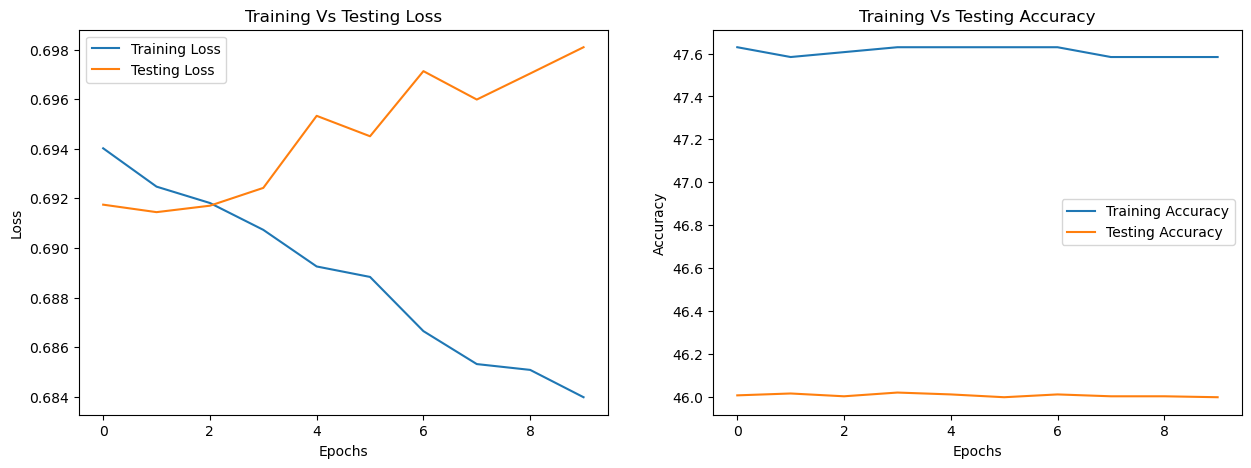

In [154]:
plt.figure(figsize=(15,5))
epochs = range(len(model_0_results['train_loss']))

plt.subplot(1,2,1)
plt.plot(epochs, model_0_results['train_loss'], label='Training Loss')
plt.plot(epochs, model_0_results['test_loss'], label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Vs Testing Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, model_0_results['train_acc'], label='Training Accuracy')
plt.plot(epochs, model_0_results['test_acc'], label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Vs Testing Accuracy')
plt.legend()

plt.show()